# Satellite imagery access and analysis in Python & Jupyter notebooks


## Access, preprocess, analyse and visualize satellite images in Jupyter notebooks with Python.

### Accessing data
In this tutorial, we will use Sentinel 2 data. There are many options to access Sentinel 2 images and most of them will require you to access through website interaction whether directly via a downloading service utility or via the cloud. However, since we are using Jupyter notebook, we will access them right here using, sentinelsat a python library which makes searching, retrieving and downloading Sentinel satellite images easy. So let us start installing sentinelsat through pip.

In [4]:
%config IPCompleter.greedy=True
import folium
import os
from zipfile import ZipFile
import numpy as np
from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt 
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
from shapely.geometry import MultiPolygon, Polygon
import rasterio as rio
from rasterio.plot import show
import rasterio.mask
import fiona
import pyproj
import gdal
from datetime import datetime
import pygc
from io import StringIO
import shutil
import cv2
from sklearn import cluster
from osgeo import gdal, gdal_array
from sklearn.cluster import KMeans
from PIL import Image
import scipy.misc
import json

In [5]:
missing_values = [r"\N"]
df0 = pd.read_csv(r'airport-codes_csv.csv',na_values = missing_values)
list1,a,b = [],[],[]
for item in df0["iata_code"]:
    list1.append(item)
    
for items in df0['coordinates']:
    a.append(items.split(',')[0])
    b.append(items.split(',')[1])

______________

In [6]:
iatalist,iatabatch= [],[]
batch_ranges = []
batch_size = 1923
batch_number = 1
missing_values = [r"\N"]
df = pd.read_csv(r'airportDB.csv')
df_all = df
 
allNames = []
for items,names in zip(df_all['IATA'],df_all['Name']):
    iatabatch.append(items)
    allNames.append(names)
    
def Remove(duplicate): 
    final_list = [] 
    for num in duplicate: 
        if num not in final_list: 
            final_list.append(num) 
    return final_list 

iatabatch = Remove(iatabatch)
chunk_items = len(iatabatch) - 1

for i in range(chunk_items):
    batch_ranges.append(iatabatch[i*batch_size : (i+1)*batch_size])
    
batch_ranges

for i in range(batch_size):
    iatalist.append(batch_ranges[batch_number -1][i])
#print(iatalist)

        

iata,iatalat,iatalon,notthere = [],[],[],[]
for key in iatalist:
    try:
        iata.append(key)
        #have changed codes --> list1 & codes[key].lat/lon --> a/b[list1.index(key)]
        iatalon.append(a[list1.index(key)])
        iatalat.append(b[list1.index(key)])
    except:
        continue

airportName = iatalist.index('MAA') + 1

In [12]:
iatalist,iatabatch= [],[]
batch_ranges = []
batch_size = 1
batch_number = airportName
missing_values = [r"\N"]
df = pd.read_csv(r'airportDB.csv')
df_all = df
 
allNames = []
for items,names in zip(df_all['IATA'],df_all['Name']):
    iatabatch.append(items)
    allNames.append(names)
    
def Remove(duplicate): 
    final_list = [] 
    for num in duplicate: 
        if num not in final_list: 
            final_list.append(num) 
    return final_list 

iatabatch = Remove(iatabatch)
chunk_items = len(iatabatch) - 1

for i in range(chunk_items):
    batch_ranges.append(iatabatch[i*batch_size : (i+1)*batch_size])
    
batch_ranges

for i in range(batch_size):
    iatalist.append(batch_ranges[batch_number -1][i])
#print(iatalist)

        

iata,iatalat,iatalon,notthere = [],[],[],[]
for key in iatalist:
    iata.append(key)
    #have changed codes --> list1 & codes[key].lat/lon --> a/b[list1.index(key)]
    iatalon.append(a[list1.index(key)])
    iatalat.append(b[list1.index(key)])


#print(iata[0],iatalat[0],iatalon[0])
#printing the entries that we have in our excel but not in our database(significantly improved results over the .dat file previously supplied)
iatalist

['MAA']

In [13]:
def latLonBoxByWandH(lat,lon,ew_width,ns_height):
    lats, lons = [], []
    #distance in m, az (in deg), lat (in deg), long (in deg)

    res = pygc.great_circle(distance=ew_width/2, azimuth=90, latitude=lat, longitude=lon)
    lat, lon = res['latitude'], res['longitude']

    res = pygc.great_circle(distance=ns_height/2, azimuth=180, latitude=lat, longitude=lon)
    lat, lon = res['latitude'], res['longitude']
    lats.append(lat), lons.append(lon)

    res = pygc.great_circle(distance=ew_width, azimuth=270, latitude=lat, longitude=lon)
    lat, lon = res['latitude'], res['longitude']
    lats.append(lat), lons.append(lon)

    res = pygc.great_circle(distance=ns_height, azimuth=0, latitude=lat, longitude=lon)
    lat, lon = res['latitude'], res['longitude']
    lats.append(lat), lons.append(lon)

    res = pygc.great_circle(distance=ew_width, azimuth=90, latitude=lat, longitude=lon)
    lat, lon = res['latitude'], res['longitude']
    lats.append(lat), lons.append(lon)
    
    return {'lats':lats,'lons':lons}


#test the function
#lengths in m
ew_width = 5000
ns_height = 5000
loc_lat,loc_lon = [], []

# iatalat = [1.419582]  
# iatalon = [103.796708]

for i in range(0,len(iata)):
    #print(iatalat[i],iatalon[i])
    loc_lat.append(iatalat[i])
    loc_lon.append(iatalon[i])


#loc_lon,loc_lat
loc_lat = np.asfarray(loc_lat,float)
loc_lon = np.asfarray(loc_lon,float)

#loc_lat = [39.509714]
#loc_lon = [116.410561]

#loc_lat = [13.052984]
#loc_lon = [80.282384]

loc_lat,loc_lon

(array([12.99000549]), array([80.16929626]))

In [14]:
polygons,footprint =[], []

for lat, lon in zip(loc_lat,loc_lon):

    box = latLonBoxByWandH(lat,lon,ew_width,ns_height)
    
    polygon_geom = Polygon(zip(box['lons'], box['lats']))
    footprint.append(polygon_geom)
    crs = {'init' : 'epsg:4326'}
    polygon = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[polygon_geom])       
    #polygon.to_crs('WGS',4326)
    polygons.append(polygon)


pyproj.Proj("init =epsg:4326")
m = folium.Map([loc_lat[0],loc_lon[0]], zoom_start=12)
for polygon in polygons:
    folium.GeoJson(polygon).add_to(m)
m


C:\Anaconda3\envs\fastai_v1\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Anaconda3\envs\fastai_v1\lib\site-packages\pyproj\crs\crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


In [15]:
user = 'demi12395' 
password = 'Sutd1234' 

api = SentinelAPI(user, password, 'https://scihub.copernicus.eu/dhus')

In [16]:
    apiq = []
    for i in range(0,len(polygons)):
        apiq.append(api.query(footprint[i],
                     date = ('20200601','20210714'),
                     platformname = 'Sentinel-2',
                     processinglevel = 'Level-2A',
                    area_relation = ('Contains'),
                              limit = 10,
                     cloudcoverpercentage = (0,5)))

In [17]:
for i in range(len(apiq)):
    print(iatalist[i],len(apiq[i]))

MAA 10


In [18]:
products_list, products_list_sorted,images,title,titlelist,best,bestlist =[],[], [], [], [] , [],[]
for products in apiq:
        products_list.append(api.to_geodataframe(products))
        
#Sorting the list of products within our array of locations for minimum cloudcover
for products in products_list:
    products_list[i].sort_values(['cloudcoverpercentage'],ascending = [True])
    
del products_list[1::2]
    
#for products in products_list:
    #print(products_list[i])
for products in products_list:
        images.append(products)

#for products in images: 
        #title.append(products.title)
        #best.append(products.uuid)
        
for items in title: 
        items[18:][:99999]
for products in images:
    for i in range(0,len(products)):
        title.append(products.title[i])
        best.append(products.uuid[i])
    bestlist.append(best)
    titlelist.append(title)
    title,best = [], []      


In [19]:
cloudy = [x for x in products_list[0]['cloudcoverpercentage']]

In [20]:
datestamp,stamp = [],[]
for k in range(0,len(bestlist)):
    for i in range(0,len(bestlist[k])):
        d = products_list[k].beginposition[i].date().strftime("%Y%m%d")
        stamp.append(d)
    datestamp.append(stamp)
    stamp = []
#products_list[1]

In [21]:
for date,clouds in zip(datestamp[0],cloudy):
    print('{} {}'.format(date, clouds))

20210530 0.361498
20210430 4.572453
20210316 4.292554
20210311 4.59395
20210306 1.213944
20210301 0.166751
20210214 1.220062
20210204 4.494434
20201121 2.990587
20201101 4.512155


In [22]:
#kth best image available
k = 0

In [23]:
prodlist = bestlist
prodlist

[['ce4119ac-c394-4dc0-8bbd-e680c2b74fa0',
  '6978aa06-ee1e-44c8-88a9-210dc7e40a07',
  '6d17a367-a4d4-4c54-90f4-27f58c8a585b',
  '7406f353-5f02-4693-b874-b9d97d61fc69',
  '7f186daf-92d8-401b-a2f1-f830c1c2d607',
  'a377fe39-a341-4a21-ab81-b24d6b98d9ce',
  '76f25896-282c-4874-8bcb-42c2eb527aba',
  '29c269ea-1b99-4bf9-a874-5ee7d179fec8',
  'bde143e2-6c91-4725-a492-8d0a8801a24f',
  '1362ab97-5cca-438c-8343-fe6f6a894a9e']]

In [24]:
titlelist

[['S2A_MSIL2A_20210530T045701_N0300_R119_T44PMV_20210530T071124',
  'S2A_MSIL2A_20210430T045651_N0300_R119_T44PMV_20210430T071033',
  'S2B_MSIL2A_20210316T045659_N0214_R119_T44PMV_20210316T080244',
  'S2A_MSIL2A_20210311T045701_N0214_R119_T44PMV_20210311T080655',
  'S2B_MSIL2A_20210306T045659_N0214_R119_T44PMV_20210306T082522',
  'S2A_MSIL2A_20210301T045721_N0214_R119_T44PMV_20210301T081035',
  'S2B_MSIL2A_20210214T045909_N0214_R119_T44PMV_20210214T071352',
  'S2B_MSIL2A_20210204T050009_N0214_R119_T44PMV_20210204T074311',
  'S2A_MSIL2A_20201121T050121_N0214_R119_T44PMV_20201121T070757',
  'S2A_MSIL2A_20201101T045941_N0214_R119_T44PMV_20201101T072126']]

In [36]:
#api.download(best[k])
for prods,titles in zip(prodlist,titlelist):
    for items,items2 in zip(prods,titles):
        try:
            print('Downloading {}   {}/{}'.format(items2,prods.index(items)+1,len(prods)))
            api.download(items)
            with ZipFile(items2 + '.zip', 'r') as zf:
                print("extracting  " + items2)
                zf.extractall('Products')
                zf.close()
                print("Unzipping complete.. Now removing the file..")
                os.remove(items2 + '.zip')
        except :
            print('Error! Skipping...')

extracting  S2A_MSIL2A_20210530T045701_N0300_R119_T44PMV_20210530T071124
Unzipping complete.. Now removing the file..
extracting  S2A_MSIL2A_20210430T045651_N0300_R119_T44PMV_20210430T071033
Unzipping complete.. Now removing the file..
extracting  S2B_MSIL2A_20210316T045659_N0214_R119_T44PMV_20210316T080244
Unzipping complete.. Now removing the file..
extracting  S2A_MSIL2A_20210311T045701_N0214_R119_T44PMV_20210311T080655
Unzipping complete.. Now removing the file..
extracting  S2B_MSIL2A_20210306T045659_N0214_R119_T44PMV_20210306T082522
Unzipping complete.. Now removing the file..
extracting  S2A_MSIL2A_20210301T045721_N0214_R119_T44PMV_20210301T081035
Unzipping complete.. Now removing the file..
extracting  S2B_MSIL2A_20210214T045909_N0214_R119_T44PMV_20210214T071352
Unzipping complete.. Now removing the file..
extracting  S2B_MSIL2A_20210204T050009_N0214_R119_T44PMV_20210204T074311
Unzipping complete.. Now removing the file..
extracting  S2A_MSIL2A_20201121T050121_N0214_R119_T44PMV

In [38]:
folder,foldername,dire,allmapsinc,allmaps,diretemp =[], [], [],[],[],[]
for titles in titlelist:
    for items in titles:
        d = os.listdir("Products/" + items + ".SAFE/" + "GRANULE")
        folder.append(d[0])
    foldername.append(folder)
    folder = []
foldername

for titles,folders in zip(titlelist,foldername):
    for items,names in zip(titles,folders):
        maindir =  "Products/" + items + ".SAFE/" + "GRANULE/"  +str(names) + "/IMG_DATA" + "/R10m"
        allmapsinc.append(maindir)
        diretemp.append(os.listdir(maindir))
    allmaps.append(allmapsinc)
    dire.append(diretemp)
    allmapsinc,diretemp = [],[]
    
allmaps

[['Products/S2A_MSIL2A_20210530T045701_N0300_R119_T44PMV_20210530T071124.SAFE/GRANULE/L2A_T44PMV_A031004_20210530T051409/IMG_DATA/R10m',
  'Products/S2A_MSIL2A_20210430T045651_N0300_R119_T44PMV_20210430T071033.SAFE/GRANULE/L2A_T44PMV_A030575_20210430T051453/IMG_DATA/R10m',
  'Products/S2B_MSIL2A_20210316T045659_N0214_R119_T44PMV_20210316T080244.SAFE/GRANULE/L2A_T44PMV_A021023_20210316T051240/IMG_DATA/R10m',
  'Products/S2A_MSIL2A_20210311T045701_N0214_R119_T44PMV_20210311T080655.SAFE/GRANULE/L2A_T44PMV_A029860_20210311T050601/IMG_DATA/R10m',
  'Products/S2B_MSIL2A_20210306T045659_N0214_R119_T44PMV_20210306T082522.SAFE/GRANULE/L2A_T44PMV_A020880_20210306T051305/IMG_DATA/R10m',
  'Products/S2A_MSIL2A_20210301T045721_N0214_R119_T44PMV_20210301T081035.SAFE/GRANULE/L2A_T44PMV_A029717_20210301T050505/IMG_DATA/R10m',
  'Products/S2B_MSIL2A_20210214T045909_N0214_R119_T44PMV_20210214T071352.SAFE/GRANULE/L2A_T44PMV_A020594_20210214T051145/IMG_DATA/R10m',
  'Products/S2B_MSIL2A_20210204T050009_N0

In [40]:
foldername

[['L2A_T44PMV_A031004_20210530T051409',
  'L2A_T44PMV_A030575_20210430T051453',
  'L2A_T44PMV_A021023_20210316T051240',
  'L2A_T44PMV_A029860_20210311T050601',
  'L2A_T44PMV_A020880_20210306T051305',
  'L2A_T44PMV_A029717_20210301T050505',
  'L2A_T44PMV_A020594_20210214T051145',
  'L2A_T44PMV_A020451_20210204T050729',
  'L2A_T44PMV_A028287_20201121T051432',
  'L2A_T44PMV_A028001_20201101T051109']]

In [41]:
dire[0]

[['T44PMV_20210530T045701_AOT_10m.jp2',
  'T44PMV_20210530T045701_B02_10m.jp2',
  'T44PMV_20210530T045701_B03_10m.jp2',
  'T44PMV_20210530T045701_B04_10m.jp2',
  'T44PMV_20210530T045701_B08_10m.jp2',
  'T44PMV_20210530T045701_TCI_10m.jp2',
  'T44PMV_20210530T045701_WVP_10m.jp2'],
 ['T44PMV_20210430T045651_AOT_10m.jp2',
  'T44PMV_20210430T045651_B02_10m.jp2',
  'T44PMV_20210430T045651_B03_10m.jp2',
  'T44PMV_20210430T045651_B04_10m.jp2',
  'T44PMV_20210430T045651_B08_10m.jp2',
  'T44PMV_20210430T045651_TCI_10m.jp2',
  'T44PMV_20210430T045651_WVP_10m.jp2'],
 ['T44PMV_20210316T045659_AOT_10m.jp2',
  'T44PMV_20210316T045659_B02_10m.jp2',
  'T44PMV_20210316T045659_B03_10m.jp2',
  'T44PMV_20210316T045659_B04_10m.jp2',
  'T44PMV_20210316T045659_B08_10m.jp2',
  'T44PMV_20210316T045659_TCI_10m.jp2',
  'T44PMV_20210316T045659_WVP_10m.jp2'],
 ['T44PMV_20210311T045701_AOT_10m.jp2',
  'T44PMV_20210311T045701_B02_10m.jp2',
  'T44PMV_20210311T045701_B03_10m.jp2',
  'T44PMV_20210311T045701_B04_10m.jp2

In [42]:
templatemp,template = [],[]
for k in range(0,len(dire)):
    for i in range(0,len(dire[0])):
        templatemp.append(dire[k][i][-2][0:][:-4])
    template.append(templatemp)
    templatemp = []
template

[['T44PMV_20210530T045701_TCI_10m',
  'T44PMV_20210430T045651_TCI_10m',
  'T44PMV_20210316T045659_TCI_10m',
  'T44PMV_20210311T045701_TCI_10m',
  'T44PMV_20210306T045659_TCI_10m',
  'T44PMV_20210301T045721_TCI_10m',
  'T44PMV_20210214T045909_TCI_10m',
  'T44PMV_20210204T050009_TCI_10m',
  'T44PMV_20201121T050121_TCI_10m',
  'T44PMV_20201101T045941_TCI_10m']]

In [43]:
allmapscompleteinc,allmapscomplete = [],[]
for k in range(0,len(prodlist)):
    for i in range(0,len(prodlist[0])):
        allmapscompleteinc.append(allmaps[k][i] + "/" + template[k][i] + ".jp2")
    allmapscomplete.append(allmapscompleteinc)
    allmapscompleteinc = []
allmapscomplete[0]


['Products/S2A_MSIL2A_20210530T045701_N0300_R119_T44PMV_20210530T071124.SAFE/GRANULE/L2A_T44PMV_A031004_20210530T051409/IMG_DATA/R10m/T44PMV_20210530T045701_TCI_10m.jp2',
 'Products/S2A_MSIL2A_20210430T045651_N0300_R119_T44PMV_20210430T071033.SAFE/GRANULE/L2A_T44PMV_A030575_20210430T051453/IMG_DATA/R10m/T44PMV_20210430T045651_TCI_10m.jp2',
 'Products/S2B_MSIL2A_20210316T045659_N0214_R119_T44PMV_20210316T080244.SAFE/GRANULE/L2A_T44PMV_A021023_20210316T051240/IMG_DATA/R10m/T44PMV_20210316T045659_TCI_10m.jp2',
 'Products/S2A_MSIL2A_20210311T045701_N0214_R119_T44PMV_20210311T080655.SAFE/GRANULE/L2A_T44PMV_A029860_20210311T050601/IMG_DATA/R10m/T44PMV_20210311T045701_TCI_10m.jp2',
 'Products/S2B_MSIL2A_20210306T045659_N0214_R119_T44PMV_20210306T082522.SAFE/GRANULE/L2A_T44PMV_A020880_20210306T051305/IMG_DATA/R10m/T44PMV_20210306T045659_TCI_10m.jp2',
 'Products/S2A_MSIL2A_20210301T045721_N0214_R119_T44PMV_20210301T081035.SAFE/GRANULE/L2A_T44PMV_A029717_20210301T050505/IMG_DATA/R10m/T44PMV_2021

In [44]:
data = rio.open(allmapscomplete[0][2])
print(data.meta['crs'])

EPSG:32644


In [45]:
data.count, data.width, data.height

(3, 10980, 10980)

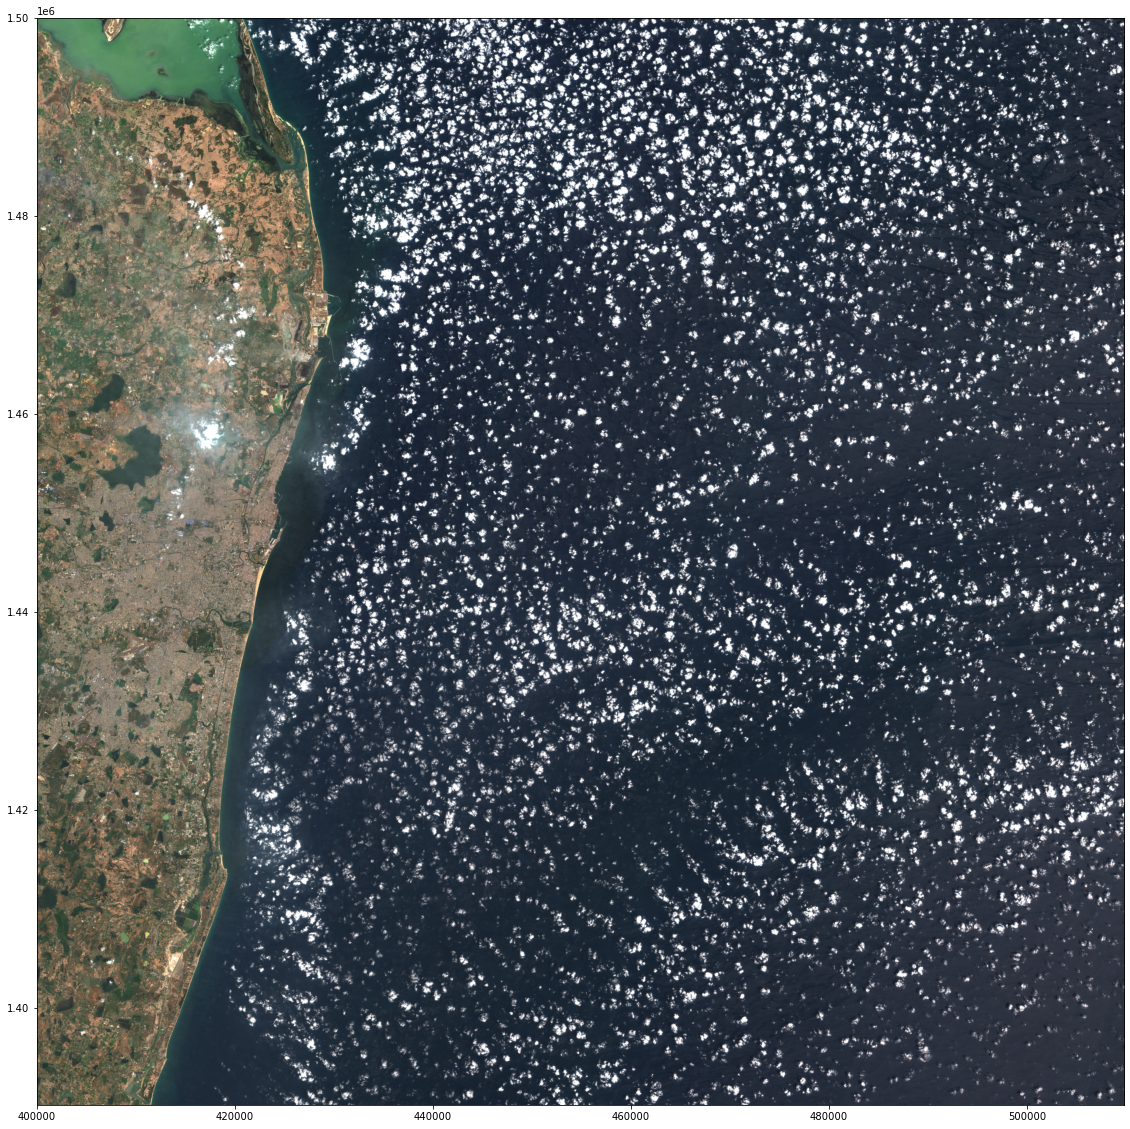

In [46]:
fig, ax = plt.subplots(1, figsize=(20, 20))
show(data, ax=ax)
plt.show()

### Mask Satellite images

In [47]:
filename,file = [],[]
gdoptions = gdal.WarpOptions(options = ['EPSG:4326','width=10980', "height=10980"])
#gdoptions = gdal.WarpOptions('dstSRS = WGS84','width = 10980','height = 10980')
for k in range(0,len(allmaps)):
    for i in range(0,len(allmaps[0])):
        input_raster = gdal.Open(allmapscomplete[k][i])
        output_raster = allmaps[k][i] + '/' + template[k][i] +".tiff"
        file.append(output_raster)
        options=['dstSRS = EPSG:4326','width = 10980', 'height = 10980']
        gdal.Warp(output_raster,input_raster,srcSRS = str(data.meta['crs']),dstSRS = 'epsg:4326',width = str(data.width),height = str(data.height))
        print("{} Finished Warping for {}_{}".format(i+1,str(k),iatalist[k]))
    filename.append(file)
    file = []
    #break


1 Finished Warping for 0_MAA
2 Finished Warping for 0_MAA
3 Finished Warping for 0_MAA
4 Finished Warping for 0_MAA
5 Finished Warping for 0_MAA
6 Finished Warping for 0_MAA
7 Finished Warping for 0_MAA
8 Finished Warping for 0_MAA
9 Finished Warping for 0_MAA
10 Finished Warping for 0_MAA


In [48]:
for items in filename[0]:
    data = rio.open(items)
print(data.meta['crs'])

EPSG:4326


In [49]:
polygons[0].crs

<Geographic 2D CRS: +init=epsg:4326 +type=crs>
Name: WGS 84
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [54]:
key = 'Airport_MAA_'

In [55]:
from rasterio.mask import mask

geoms,namesofFiles = [],[]
for i in range(0,len(datestamp)):
    geoms.append(polygons[i]['geometry'])

for k in range(0,len(prodlist)):
    for i in range(0,len(prodlist[0])):
        with rasterio.open(filename[k][i]) as src:
            out_image, out_transform = mask(src, geoms[0], crop=True)
            out_meta = src.meta.copy()

        out_meta.update({"driver": "GTiff",
                         "height": out_image.shape[1],
                         "width": out_image.shape[2],
                         "transform": out_transform
                        })
        files = 'Source/S1_' + key + datestamp[k][i] + '.tiff'
        namesofFiles.append(files)
        with rasterio.open(files, "w", **out_meta) as dest:
            dest.write(out_image)
        #os.remove(titlelist[k][i])

In [56]:
namesofFiles

['Source/S1_Airport_MAA_20210530.tiff',
 'Source/S1_Airport_MAA_20210430.tiff',
 'Source/S1_Airport_MAA_20210316.tiff',
 'Source/S1_Airport_MAA_20210311.tiff',
 'Source/S1_Airport_MAA_20210306.tiff',
 'Source/S1_Airport_MAA_20210301.tiff',
 'Source/S1_Airport_MAA_20210214.tiff',
 'Source/S1_Airport_MAA_20210204.tiff',
 'Source/S1_Airport_MAA_20201121.tiff',
 'Source/S1_Airport_MAA_20201101.tiff']

### Save as GIF

In [57]:
from PIL import Image, ImageDraw,ImageFont
images = []

for things,i in zip(reversed(namesofFiles),reversed(datestamp[0])):
    img = Image.open(things)
    draw = ImageDraw.Draw(img)
    font = ImageFont.truetype("arial.ttf", 18)
    draw.text((50, 50),str(i),(255,255,255),font=font)
    images.append(img)
images[0].save(key + iatalist[0] + '.gif',
              save_all=True, append_images=images[1:], optimize=True, duration=800, loop=0)   

### Save as Video

In [257]:
import cv2
import os

video_name = key + iatalist[0] + '.avi'

frame = cv2.imread(namesofFiles[0])
height, width, layers = frame.shape

video = cv2.VideoWriter(video_name, 0, 1, (width,height))

for image in reversed(namesofFiles):
    video.write(cv2.imread(image))

cv2.destroyAllWindows()
video.release()